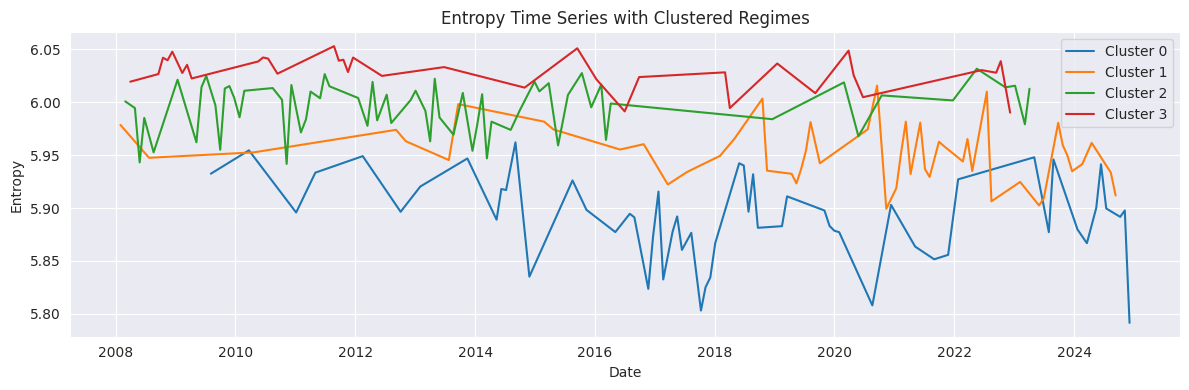

In [2]:
import pandas as pd
from mistune.toc import render_toc_ul
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your feature CSV
# Load your feature CSV
df = pd.read_csv("../data/data.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)

# Clean lambda columns
for col in ["Lambda_max", "Lambda_2", "Lambda_3"]:
    df[col] = df[col].apply(lambda x: float(str(x).replace("(", "").replace(")", "").split("+")[0]))

# Define feature columns
features = [
    "Shannon_Entropy", "Average_Degree", "Network_Entropy",
    "Mean_Correlation", "Lambda_max", "Lambda_2", "Lambda_3"
]

# Standardize features
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(df[features])

# Cluster
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# Plot entropy with cluster color
plt.figure(figsize=(12, 4))
for label in sorted(df["Cluster"].unique()):
    subset = df[df["Cluster"] == label]
    plt.plot(subset.index, subset["Shannon_Entropy"], label=f"Cluster {label}")
plt.legend()
plt.title("Entropy Time Series with Clustered Regimes")
plt.ylabel("Entropy")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


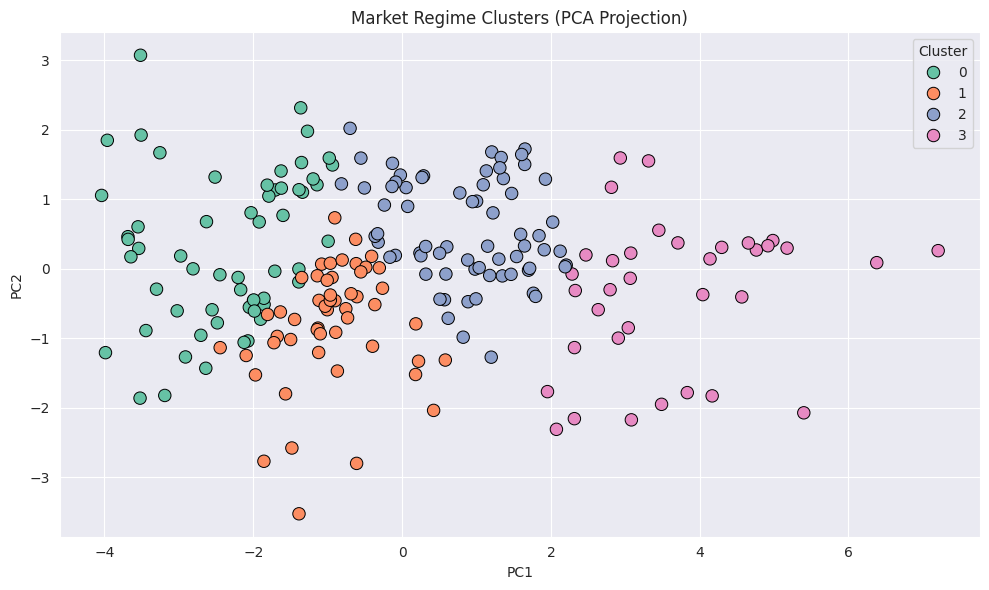

In [3]:
from sklearn.decomposition import PCA
import seaborn as sns

# Perform PCA
pca = PCA(n_components=2)
components = pca.fit_transform(X)

# Add to DataFrame
df["PC1"] = components[:, 0]
df["PC2"] = components[:, 1]

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="Cluster",
    palette="Set2",
    data=df,
    s=80, edgecolor='k'
)
plt.title("Market Regime Clusters (PCA Projection)")
plt.grid(True)
plt.tight_layout()
plt.show()


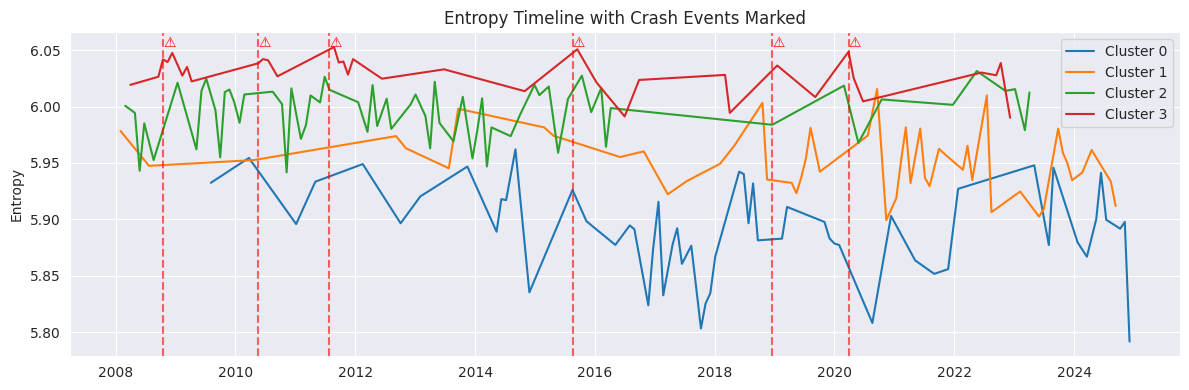

In [4]:
crash_dates = [
    "2008-10-16", "2010-05-20", "2011-07-28",
    "2015-08-18", "2018-12-18", "2020-03-27"
]

plt.figure(figsize=(12, 4))

for label in sorted(df["Cluster"].unique()):
    subset = df[df["Cluster"] == label]
    plt.plot(subset.index, subset["Shannon_Entropy"], label=f"Cluster {label}")

for date in crash_dates:
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--', alpha=0.6)
    plt.text(pd.to_datetime(date), df["Shannon_Entropy"].max(), "⚠", color='red')

plt.legend()
plt.title("Entropy Timeline with Crash Events Marked")
plt.ylabel("Entropy")
plt.grid(True)
plt.tight_layout()
plt.show()

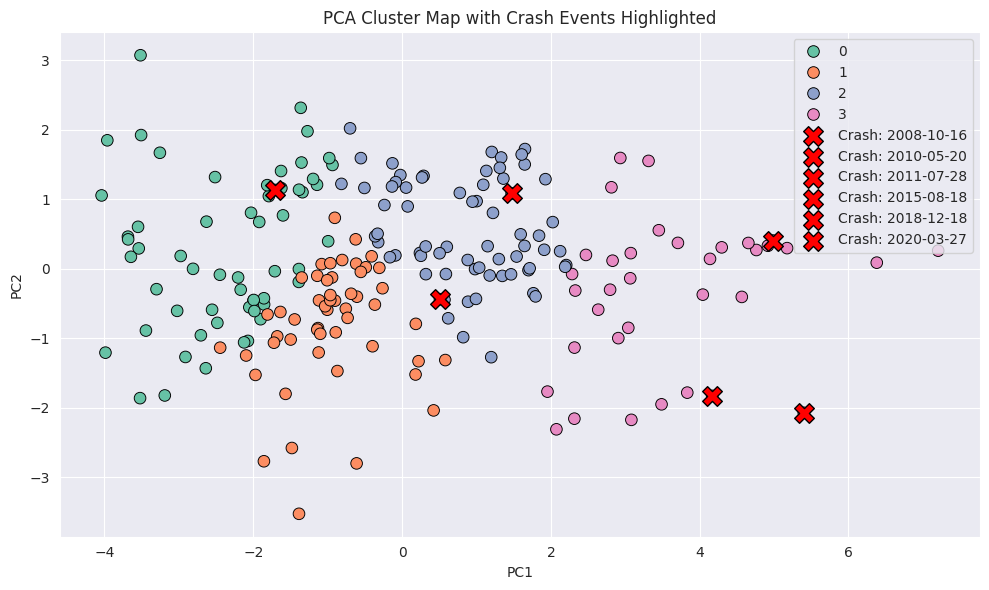

In [5]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="Cluster",
    palette="Set2",
    data=df,
    s=70, edgecolor='k'
)

# Highlight crash points
for crash_date in crash_dates:
    try:
        row = df.loc[pd.to_datetime(crash_date)]
        plt.scatter(row["PC1"], row["PC2"], s=200, color='red', edgecolor='black', marker='X', label=f"Crash: {crash_date}")
    except KeyError:
        continue

plt.title("PCA Cluster Map with Crash Events Highlighted")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
from src.clustering import build_lstm_data
from src.lstm_dataset import RegimeDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Step 1: Build sequences
X, y = build_lstm_data(df, features, label_col="Cluster", window_size=20)

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Step 3: Load into PyTorch
train_ds = RegimeDataset(X_train, y_train)
test_ds = RegimeDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


In [7]:
from src.lstm_model import RegimeLSTM
import torch.nn as nn
import torch.optim as optim
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RegimeLSTM().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")


def evaluate_model(model, test_loader):
    model.eval()
    correct = total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)

            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    return all_preds, all_labels


train_model(model, train_loader, criterion, optimizer, num_epochs=25)
preds, labels = evaluate_model(model, test_loader)



Epoch 1/25 - Loss: 1.3902
Epoch 2/25 - Loss: 1.3636
Epoch 3/25 - Loss: 1.3382
Epoch 4/25 - Loss: 1.3247
Epoch 5/25 - Loss: 1.3107
Epoch 6/25 - Loss: 1.2961
Epoch 7/25 - Loss: 1.2786
Epoch 8/25 - Loss: 1.2618
Epoch 9/25 - Loss: 1.2415
Epoch 10/25 - Loss: 1.2297
Epoch 11/25 - Loss: 1.2174
Epoch 12/25 - Loss: 1.2056
Epoch 13/25 - Loss: 1.1730
Epoch 14/25 - Loss: 1.1839
Epoch 15/25 - Loss: 1.1865
Epoch 16/25 - Loss: 1.1826
Epoch 17/25 - Loss: 1.1706
Epoch 18/25 - Loss: 1.1566
Epoch 19/25 - Loss: 1.1633
Epoch 20/25 - Loss: 1.1547
Epoch 21/25 - Loss: 1.1456
Epoch 22/25 - Loss: 1.1189
Epoch 23/25 - Loss: 1.1271
Epoch 24/25 - Loss: 1.1229
Epoch 25/25 - Loss: 1.0965
Test Accuracy: 0.4103


In [8]:
from src.transformer_model import TransformerClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerClassifier(
    seq_len=20,       # how many days in the input window
    input_dim=7,      # number of features
    emb_dim=64,       # hidden size of transformer
    num_heads=4,      # number of attention heads
    num_classes=4     # regime clusters
).to(device)

train_model(model, train_loader, criterion, optimizer, num_epochs=25)
preds, labels = evaluate_model(model, test_loader)



Epoch 1/25 - Loss: 1.4037
Epoch 2/25 - Loss: 1.4039
Epoch 3/25 - Loss: 1.4075
Epoch 4/25 - Loss: 1.4120
Epoch 5/25 - Loss: 1.4068
Epoch 6/25 - Loss: 1.4062
Epoch 7/25 - Loss: 1.4119
Epoch 8/25 - Loss: 1.4032
Epoch 9/25 - Loss: 1.4074
Epoch 10/25 - Loss: 1.4076
Epoch 11/25 - Loss: 1.4064
Epoch 12/25 - Loss: 1.4105
Epoch 13/25 - Loss: 1.4074
Epoch 14/25 - Loss: 1.4062
Epoch 15/25 - Loss: 1.4100
Epoch 16/25 - Loss: 1.4052
Epoch 17/25 - Loss: 1.4086
Epoch 18/25 - Loss: 1.4080
Epoch 19/25 - Loss: 1.4087
Epoch 20/25 - Loss: 1.4075
Epoch 21/25 - Loss: 1.4073
Epoch 22/25 - Loss: 1.4113
Epoch 23/25 - Loss: 1.4079
Epoch 24/25 - Loss: 1.4078
Epoch 25/25 - Loss: 1.4053
Test Accuracy: 0.2308


torch.Size([1, 20, 20])


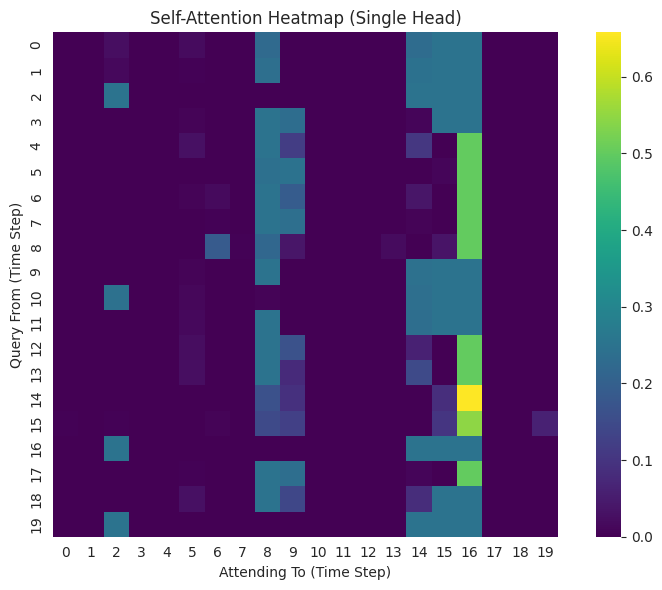

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Pick one sample
sample_idx = 0
X_sample, _ = test_ds[0]
X_sample = X_sample.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    _, attn_weights = model(X_sample, return_attention=True)

print(attn_weights.shape)  # should be [batch_size, num_heads, seq_len, seq_len]


weights = attn_weights[0].cpu().numpy()  # shape: [20, 20]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(weights, annot=False, cmap="viridis", square=True, cbar=True)
plt.title("Self-Attention Heatmap (Single Head)")
plt.xlabel("Attending To (Time Step)")
plt.ylabel("Query From (Time Step)")
plt.tight_layout()
plt.show()
